# Vector Converter

## Step 1. Import needed packages

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as image_preprocessing
import tensorflow.keras.backend as tf_backend 
tf_backend.set_image_data_format('channels_last')

# Import all other needed packages
import numpy as np
import csv
from PIL import Image
import random

%matplotlib inline

## Step 2. Generate train & test datasets

In [2]:
# Forming feature vectors dictionary
feature_vectors_dictionary = {}

with open('./output/keras_facenet_feature_vectors.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        if i == 0:
            continue
        
        person_id = int(float(row[0]))
        feature_vector = np.array(row[2:])
        feature_vector = feature_vector.astype(np.float)
        
        if person_id not in feature_vectors_dictionary:
            feature_vectors_dictionary[person_id] = [feature_vector]
            continue
            
        feature_vectors_dictionary[person_id].append(feature_vector)

dictionary_values = list(feature_vectors_dictionary.values()) 
        
# Finding minimal array size
min_array_length = int(1e10)
for value in dictionary_values:
    min_array_length = min(min_array_length, len(value))

# Forming tensorflow and numpy arrays
feature_vector_batches_np = []
feature_vector_batches_tf = []
labels = []

for key in feature_vectors_dictionary:
    value = feature_vectors_dictionary[key]
    value_np = np.array(value[:min_array_length])
    labels.extend([key] * min_array_length)
    feature_vector_batches_np.extend(value_np)
    feature_vector_batches_tf.extend(tf.convert_to_tensor(value_np))

2023-01-15 00:50:08.244882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 00:50:08.245929: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# Shuffle two lists
temp = list(zip(feature_vector_batches_np, feature_vector_batches_tf, labels))
random.shuffle(temp)
temp_batches_np, temp_batches_tf, temp_labels = zip(*temp)
feature_vector_batches_np, feature_vector_batches_tf, labels = list(temp_batches_np), list(temp_batches_tf), list(temp_labels)

feature_vector_batches_tf = tf.stack(feature_vector_batches_tf)

# Test shuffling
def euclidean_distance(f1, f2):
    return tf.reduce_sum(tf.square(f1-f2), axis=0)

anchor, anchor_label = feature_vector_batches_tf[0], labels[0]

positive_id, negative_id = -1, -1 
for i, vector in enumerate(feature_vector_batches_np):
    if i == 0:
        continue
    if positive_id >= 0 and negative_id >= 0:
        break
    if labels[i] != anchor_label and negative_id == -1:
        negative_id = i
    if labels[i] == anchor_label and positive_id == -1:
        positive_id = i

negative, positive = feature_vector_batches_tf[negative_id], feature_vector_batches_tf[positive_id]
negative_label, positive_label = labels[negative_id], labels[positive_id]
        
print('Anchor, Negative, and Positive labels are {}, {}, and {}'.format(anchor_label, negative_label, positive_label))
print('Distance between anchor and negative is {}'.format(euclidean_distance(anchor, negative)))
print('Distance between anchor and positive is {}'.format(euclidean_distance(anchor, positive)))    

# Splitting into training and test sets
total_dataset_length = len(labels)
test_proportion = 0.8
train_length = int(test_proportion * total_dataset_length)

X_train = feature_vector_batches_tf[:train_length]
Y_train = labels[:train_length]

X_test = feature_vector_batches_tf[train_length:]
Y_test = labels[train_length:]

print('Total dataset length: {}'.format(total_dataset_length))
print('Length of a train dataset: {}'.format(len(X_train)))
print('Length of a test dataset: {}'.format(len(X_test)))

Anchor, Negative, and Positive labels are 72, 123, and 72
Distance between anchor and negative is 263.00629066112015
Distance between anchor and positive is 54.884614391208856
Total dataset length: 5512
Length of a train dataset: 4409
Length of a test dataset: 1103


## Step 3. Define distance function

Suppose we have two feature vectors $\mathbf{f}$ and $\mathbf{g}$ and suppose we have a model $\mu: \mathbb{R}^N \to \mathbb{R}^N$

Since we need a function $\psi: \mathbb{R}^N \to \Sigma^N$ we define it as follows:
$$
\psi(\mathbf{f}) = \begin{cases} 1, \mu(\mathbf{f}) \geq 0 \\ 0, \mu(\mathbf{f}) < 0 \end{cases}
$$

Therefore, our binary distance has a form:
$$
\delta(\mathbf{f}, \mathbf{g}) = \frac{1}{N}\sum_{k=1}^N |\psi(\mathbf{f})_k - \psi(\mathbf{g})_k|
$$

In [4]:
def binary_distance(s1, s2):
    return tf.reduce_mean(tf.abs(s1-s2),axis=0)

# Check binary distance formula
s1 = tf.constant([0.0, 0.0, 1.0, 1.0])
s2 = tf.constant([0.0, 0.0, 1.0, 0.0])
print(binary_distance(s1, s2))

def convert_to_binary_string(f):
    return tf.where(tf.less(f, 0.0), 0.0, 1.0)

f = tf.constant([1.3, 2.5, -2.3, 0.2, -0.3])
print(convert_to_binary_string(f))

def binary_distance_vectors(f1, f2):
    return binary_distance(convert_to_binary_string(f1), convert_to_binary_string(f2))

f1 = tf.constant([-0.2, -0.3, 0.4, 0.5])
f2 = tf.constant([-0.6, -0.7, 0.8, -0.9])
print(binary_distance_vectors(f1, f2))

tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor([1. 1. 0. 1. 0.], shape=(5,), dtype=float32)
tf.Tensor(0.25, shape=(), dtype=float32)


## Step 4. Creating functions to create batches & triplets

In [32]:
def create_batch(batch_size=256, split = "train"):
    x_anchors = np.zeros((batch_size, 128))
    x_positives = np.zeros((batch_size, 128))
    x_negatives = np.zeros((batch_size, 128))
    
    if split == "train":
        data = X_train
        data_y = Y_train
    elif split == "test":
        data = X_test
        data_y = Y_test
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, data.shape[0] - 1)
        x_anchor = data[random_index]
        y = data_y[random_index]
        
        indices_for_pos = [index for index in data_y if index == y]
        indices_for_neg = [index for index in data_y if index != y]
        
        x_positive = data[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = data[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [24]:
def create_hard_batch(batch_size, num_hard, split="train"):
    x_anchors = np.zeros((batch_size, 128))
    x_positives = np.zeros((batch_size, 128))
    x_negatives = np.zeros((batch_size, 128))
    
    if split == "train":
        data = X_train
        data_y = Y_train
    elif split == "test":
        data = X_test
        data_y = Y_test
    
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split))
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_losses.append(binary_distance_vectors(A_emb, P_emb)-binary_distance_vectors(A_emb,P_emb))
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses,hard_batches), key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]

## Step 5. Creating SNN

In [7]:
# Model would consist of 3 dense layers of the same length as of feature vectors
def init_embedding_model():
    embedding_model = keras.Sequential([
        layers.Dense(128, input_shape=(128,), activation="relu", name="dense_layer_1"),
        layers.Dense(128, activation="relu", name="dense_layer_2"),
        layers.Dense(128, name="dense_layer_3"),
    ])
    
    embedding_model.summary()
    return embedding_model

def init_snn(embedding_model):
    input_anchor = layers.Input(shape=(128,))
    input_positive = layers.Input(shape=(128,))
    input_negative = layers.Input(shape=(128,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
    
    siamese_net = keras.models.Model([input_anchor, input_positive, input_negative], output)
    siamese_net.summary()
    
    return siamese_net

In [8]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size],y_pred[:,2*emb_size:]
    positive_distance = binary_distance_vectors(anchor, positive)
    negative_distance = binary_distance_vectors(anchor, negative)
    return tf.maximum(positive_distance - negative_distance + alpha, 0.)

In [9]:
def data_generator(batch_size=256, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

## Step 6. Setting up for training and evaluation

In [10]:
from tensorflow.keras.optimizers import Adam

# Hyperparams
batch_size = 256
epochs = 10
steps_per_epoch = int(X_train.shape[0]/batch_size)
val_steps = int(X_test.shape[0]/batch_size)
alpha = 0.3
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
lr = 0.00006
optimiser = 'Adam'

with tf.device("/cpu:0"):
    # Create the embedding model
    print("Generating embedding model... \n")
    embedding_model = init_embedding_model()
    
    print("\nGenerating SNN... \n")
    # Create the SNN
    siamese_net = init_snn(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj)

Generating embedding model... 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_1 (Dense)       (None, 128)               16512     
                                                                 
 dense_layer_2 (Dense)       (None, 128)               16512     
                                                                 
 dense_layer_3 (Dense)       (None, 128)               16512     
                                                                 
Total params: 49,536
Trainable params: 49,536
Non-trainable params: 0
_________________________________________________________________

Generating SNN... 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]     

## Step 7. Some random shit I do not understand for now

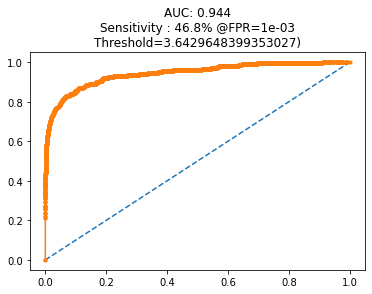

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import math

num_classes = len(np.unique(Y_train))

def compute_dist(a,b):
    return np.linalg.norm(a-b)

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all imgs with current embedding network
    embeddings = embedding_model.predict(X)
    
    k = 0
    
    # For each img in the evaluation set
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tSAME".format(i,j,probs[k],k, Y[i], Y[j]))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : {2}\tDIFF".format(i,j,probs[k],k, Y[i], Y[j]))
                k += 1
    return probs, y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_interdist(network, epochs):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(num_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(epochs))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(num_classes))

    plt.show()
    

def evaluate(embedding_model, epochs = 0):
    probs,yprob = compute_probs(embedding_model, X_test[:500, :], Y_test[:500])
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)
 
evaluate(embedding_model)

In [42]:
examples = create_batch(1)
print("Example triplet batch:")
print("Distance AP:", binary_distance_vectors(examples[0][0], examples[1][0]))
print("Distance AN:", binary_distance_vectors(examples[0][0], examples[2][0]))

print("Example semi-hard triplet batch:")
# 1 example, containing 1 semi-hard
ex_hard = create_hard_batch(1, 1, split="train")
print("Distance AP:", binary_distance_vectors(ex_hard[0][0], ex_hard[1][0]))
print("Distance AN:", binary_distance_vectors(ex_hard[0][0], ex_hard[2][0]))

Example triplet batch:
Distance AP: tf.Tensor(0.5703125, shape=(), dtype=float32)
Distance AN: tf.Tensor(0.5859375, shape=(), dtype=float32)
Example semi-hard triplet batch:
Distance AP: tf.Tensor(0.4453125, shape=(), dtype=float32)
Distance AN: tf.Tensor(0.5390625, shape=(), dtype=float32)


## Step 8. Logging

In [47]:
import os
import json
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOG",dt)

## Use a custom non-dt name:
name = "snn-run"
logdir = os.path.join("./log",name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.verbose == 1:
                print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current
            
            # Delete the last best emb_model and snn_model
            delete_older_model_files(filepath)

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : val_steps, 
               'alpha' : alpha, 
               'num_hard' : num_hard, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : 128
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)
    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [file.split("-")[1].split(".h5")[0] for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = emb_model_files_epoch_nums[-1]

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if highest_epoch_num not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file:", emb_model_files_without_highest)
        for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
            for file in model_file_list:
                os.remove(os.path.join(model_dir, file))

## Step 9. Training

In [54]:
## Training:
print("Logging out to Tensorboard at:", logdir)
print("Starting training process!")
print("-------------------------------------")

batch_per_gpu = int(batch_size)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj)

siamese_history = siamese_net.fit(
    data_generator(batch_per_gpu, num_hard),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks, 
    workers = 0, 
    validation_data = data_generator(batch_per_gpu, num_hard, split="test"), 
    validation_steps = val_steps)

print("-------------------------------------")
print("Training complete.")

Logging out to Tensorboard at: ./log/snn-run
Starting training process!
-------------------------------------


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()